In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
from flashgeotext.geotext import GeoText
import re

In [ ]:
import hashlib

def md5hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()

In [ ]:
record_col="UT (Unique WOS ID)"
outfile = r"C:\Users\radvanyi\PycharmProjects\ZSI_analytics\WOS\wos_extract\wos_records_concat.csv"

In [ ]:
wos = pd.read_csv(outfile, sep="\t",low_memory=False)

wos = wos[((wos["Publication Year"]<2023)&(wos["Publication Year"]>2010))].copy()
print(f'Number of initial (valid interval) records: {len(wos)}')

metrix = pd.read_excel("sm_journal_classification.xlsx", sheet_name="Journal_Classification")


metrix = metrix.set_index([c for c in metrix.columns if "issn" not in c]).stack().reset_index()
metrix = metrix.rename(columns={'level_6':"issn_type", 0:"issn"})
metrix["issn"]=metrix["issn"].str.replace("-","").str.lower().str.strip()

wos["issn"] = wos["ISSN"].str.replace("-","").str.lower().str.strip()
wos["eissn"] = wos["eISSN"].str.replace("-","").str.lower().str.strip()
wos = wos.set_index([c for c in wos.columns if "issn" not in c]).stack().reset_index()
wos = wos.rename(columns={'level_71':"issn_var", 0:"issn"})

wos_merge = wos.merge(metrix, on="issn", how="left")



wos_indexed = wos_merge[~wos_merge["Domain_English"].isna()]
wos_unindexed = wos_merge[~wos_merge[record_col].isin(wos_indexed[record_col])]


wos_unindexed = wos_unindexed.sort_values(by=["issn_var"],ascending=False).drop_duplicates(subset=record_col)
wos = wos_indexed.sort_values(by=["issn_var"],ascending=False).drop_duplicates(subset=record_col)

wos_postmerge = wos.copy()
print(f'Number of METRIX filtered records: {len(wos)}')
print(f'Number of unindexed records: {len(wos_unindexed)}')

# drop entries not indexed by metrix
# drop duplicates (based on doi)
wos = wos[~((~wos["DOI"].isna())&(wos["DOI"].duplicated(False)))]
wos = wos.drop_duplicates(subset=["Publication Type","Document Type","Authors","Article Title","Source Title","Publication Year"])
print(f'Number of filtered records (dropping duplicates): {len(wos)}')

In [ ]:
wos["Domain_English"].value_counts()

In [ ]:
wos_classifier = wos[["WoS Categories","Research Areas"]+list(metrix.columns)].copy().drop_duplicates()
wos_classifier = wos_classifier.groupby(["WoS Categories","Research Areas"], as_index=False)[["Domain_English","Field_English","SubField_English"]].agg(
    lambda x: pd.Series.mode(x)[0])

In [ ]:
wos_to_reindex = wos_unindexed.drop(columns=list(metrix.columns))
wos_found = wos_to_reindex.merge(wos_classifier, on=["WoS Categories","Research Areas"], how="inner")
# wos_found = wos_to_reindex.merge(wos_classifier, on="Research Areas", how="inner")
# # wos_found = wos_to_reindex.merge(wos_classifier, on="WoS Categories", how="inner")
wos_stillost = wos_unindexed[~wos_unindexed[record_col].isin(wos_found[record_col])]

print("Found:", wos_found[record_col].nunique(),"\nLost forever:", wos_stillost[record_col].nunique())

In [ ]:
wos = pd.concat([wos,wos_found], ignore_index=True)
print(f'Number of records (after remerge): {len(wos)}')

In [ ]:
wos["Domain_English"].value_counts()

In [ ]:
wos_cat = wos.groupby(record_col)["WoS Categories"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_cat["WoS Categories"] = wos_cat["WoS Categories"].str.strip()
wos_cat["WoS Categories"].value_counts()

In [ ]:
wos_subcat = wos_cat.copy()
wos_subcat[['WoS Category', 'WoS SubCategory']] = wos_subcat["WoS Categories"].str.split(",", expand = True, n=1)
for c in ['WoS Category', 'WoS SubCategory',"WoS Categories"]:
    wos_subcat[c] = wos_subcat[c].str.strip()
wos_subcat.drop_duplicates(subset=[record_col,'WoS Category'])["WoS Category"].value_counts()

In [ ]:
wos_areas = wos.groupby(record_col)["Research Areas"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_areas["Research Areas"] = wos_areas["Research Areas"].str.strip()
wos_areas["Research Areas"].value_counts()

In [ ]:
wos[["Article Title","Keywords Plus","Author Keywords"]].sample(100)

In [ ]:
kw_df = pd.DataFrame()
for c in ["Keywords Plus","Author Keywords"]:
    kwp = wos.groupby(record_col)[c].apply(lambda x: x.str.split(';')).explode().str.strip().str.upper()
    kwp.name = 'keyword_all'
    kw_df = pd.concat([kwp.reset_index(),kw_df],ignore_index=True)
kw_df = kw_df[~kw_df["keyword_all"].isna()].copy().drop(columns="level_1").drop_duplicates()
kw_df["keyword_all"] = kw_df["keyword_all"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
kw_df.head(100)

In [ ]:
wos_kwd_concat = kw_df.groupby(record_col, as_index=False).agg({'keyword_all': '; '.join})
wos_kwd_concat.head()

In [ ]:
wos.columns

In [ ]:
geotext = GeoText()

def extract_location(input_text, key='countries'):
    anomalies = {"Malta":"Malta",
                 "Mongolia":"Mongolia",
                 "Quatar":"Qatar",
                 "Qatar":"Qatar",
                 "Ethiop":"Ethiopia",
                 "Nigeria":"Nigeria",
                 "BELAR":"Belarus",
                 "Venezuela":"Venezuela",
                 "Cyprus":"Cyprus",
                 "Ecuador":"Ecuador",
                 "U Arab":"United Arab Emirates",
                 "Syria":"Syria",
                 "Uganda":"Uganda",
                 "Yemen":"Yemen",
                 "Mali":"Mali",
                 "Senegal":"Senegal",
                 "Vatican":"Vatican",
                 "Uruguay":"Uruguay",
                 "Panama":"Panama",
                 "Fiji":"Fiji",
                 "Faroe":"Faroe Islands",
                 "Macedonia":"Macedonia",
                 'Mozambique':'Mozambique',
                 "Kuwait":"Kuwait",
                 "Libya":"Libya",
                 "Turkiy":"Turkey",
                 "Liberia":"Liberia",
                 "Namibia":"Namibia",
                 "Ivoire":"Ivory Coast",
                 "Guatemala":"Gutemala",
                 "Paraguay":"Paraguay",
                 "Honduras":"Honduras",
                 "Nicaragua":"Nicaragua",
                 "Trinidad":"Trinidad & Tobago",
                 "Liechtenstein":"Liechtenstein",
                 "Greenland":"Denmark"}

    extracted = geotext.extract(input_text=input_text)
    found = extracted[key].keys()
    if len(sorted(found))>0:
        return sorted(found)[0]
    elif key=='countries':
        for i  in ['Scotland','Wales','England', 'N Ireland']:
            if i in input_text:
                return 'United Kingdom'
        for j in anomalies.keys():
            if j in input_text:
                return anomalies.get(j)
    else:
        return None

with open('../eu_members.txt',"r") as f:
    eu_countries=f.readline().split(",")
    eu_countries=[i.strip() for i in eu_countries]

def country_cleanup(country):
    if "USA" in country:
        return "USA"
    elif "China" in country:
        return "China"
    elif country in ["England", "Northern Ireland", "Wales", "Scotland","N Ireland"]:
        return "United Kingdom"
    else:
        return country


def country_type(country):
    if country in eu_countries:
        return "EU"
    elif country=="China":
        return "China"
    elif country in ["Switzerland", 'Norway','United Kingdom']:
        return "Non-EU associate"
    else:
        return "Other"


In [ ]:
locations = wos.groupby(record_col)["Addresses"].apply(lambda x: x.str.split('[')).explode().reset_index().drop(columns="level_1")


locations = locations[locations["Addresses"]!=""].copy()
locations["Address"] = locations["Addresses"].apply(lambda x:x.split("]")[-1])
locations["Authors_of_address"] = locations["Addresses"].apply(lambda x:x.split("]")[0])

In [ ]:
len(locations)

In [ ]:
locations["Address"] = locations["Address"].str.strip().str.strip(";")
locations = locations.groupby([record_col,"Authors_of_address"])["Address"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_2")
locations.head(100)

In [ ]:
# import dask.dataframe as dd
#
# locations_ddf = dd.from_pandas(locations, npartitions=4)  # convert pandas DataFrame to Dask DataFrame
# loc_compute = locations_ddf.groupby([record_col,"Authors_of_address"])["Address"].apply(lambda x: x.str.split(';')).explode().compute()  # compute the result

In [ ]:
# locations_test = locations.head(1000)
# locations_test = locations_test.groupby([record_col,"Authors_of_address"])["Address"].str.split(';').explode()
# locations_test

In [ ]:

# locations["Country"]=locations['Address'].apply(lambda x: extract_location(input_text=x, key='countries'))
locations["Country"]=locations['Address'].apply(lambda x: x.split(",")[-1].strip(" ").strip(";").strip(" "))
locations["Country"]=locations['Country'].apply(lambda x: country_cleanup(x))
locations["City"]=locations['Address'].apply(lambda x: extract_location(input_text=x, key='cities'))
locations["Country_Type"] = locations["Country"].apply(lambda x: country_type(x))

In [ ]:
scope_types = ["EU","China","Non-EU associate"]
locations=locations[locations["Country_Type"].isin(scope_types)]

In [ ]:
univ_locations = locations[[record_col,"Address","Country","City","Country_Type"]].copy()
univ_locations["Institution"] = univ_locations["Address"].apply(lambda x: x.split(",")[0])
univ_locations = univ_locations.drop_duplicates()
univ_locations.head()

In [ ]:
author_locations = locations.groupby([record_col,"Country","Country_Type"])["Authors_of_address"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_3")
author_locations["Author_name"] = author_locations["Authors_of_address"].str.strip()
author_locations = author_locations.drop(columns="Authors_of_address")
author_locations["author_str_id"] = author_locations["Author_name"].apply(lambda x:''.join(filter(str.isalnum, x.lower())))
author_locations["author_str_id"] = author_locations["author_str_id"].apply(md5hash)
author_locations = author_locations.drop(columns="Author_name")
author_locations.head()

In [ ]:
author_locations[author_locations['author_str_id'].duplicated(False)]

In [ ]:
author_primary_region = author_locations.sort_values(by="Country_Type").drop_duplicates(subset=[record_col,"author_str_id"])
# author_primary_region

china=author_primary_region[author_primary_region["Country_Type"]=="China"][record_col].unique()
eu=author_primary_region[author_primary_region["Country_Type"]=="EU"][record_col].unique()
assoc=author_primary_region[author_primary_region["Country_Type"]=="Non-EU associate"][record_col].unique()


# records that have distinct authors with different country affiliations
valid_scope = wos[((wos[record_col].isin(china))
         &
         ((wos[record_col].isin(eu))
         |
         (wos[record_col].isin(assoc))))][record_col].unique()

In [ ]:
author_primary_region.head()

In [ ]:
print(f'Number of records: {len(wos)}')
print(f'Number of valid cooperation records: {len(valid_scope)}')

In [ ]:
wos = wos[wos[record_col].isin(valid_scope)]
locations = locations[locations[record_col].isin(valid_scope)]
univ_locations = univ_locations[univ_locations[record_col].isin(valid_scope)]
author_locations = author_locations[author_locations[record_col].isin(valid_scope)]
author_primary_region = author_locations[author_locations[record_col].isin(valid_scope)]

In [ ]:
affiliations = wos.groupby(record_col)["Affiliations"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
affiliations["Affiliations"] = affiliations["Affiliations"].str.strip().str.upper().fillna("UNKNOWN")
affiliations = affiliations.drop_duplicates()

In [ ]:
affiliations["Affiliations"].value_counts()

In [ ]:
univ_locations["Institution"].value_counts()

In [ ]:
univ_locations[record_col].nunique()

In [ ]:
affiliations[record_col].nunique()

In [ ]:
univ_locations["Institution"].value_counts().sum()

In [ ]:
affiliations["Affiliations"].value_counts().sum()

In [ ]:
wos_cat = wos.groupby(record_col)["WoS Categories"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_cat["WoS Categories"].value_counts()

In [ ]:
wos_areas = wos.groupby(record_col)["Research Areas"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_areas["Research Areas"] = wos_areas["Research Areas"].str.strip()
wos_areas["Research Areas"].value_counts()

In [ ]:
[c for c in wos.columns if "_English" in c]

In [ ]:
metrix_levels = [c for c in wos.columns if "_English" in c]
for m in metrix_levels:
    wos[m] = wos[m].replace({"article-level classification":"Multidisciplinary"})


In [ ]:
wos

In [ ]:
metrix_levels

In [ ]:
record_countries = locations[[record_col,"Country"]].drop_duplicates()
record_author_locations = author_locations[[record_col,"author_str_id","Country"]].drop_duplicates()
record_institution = univ_locations[[record_col,"Institution","Country"]].drop_duplicates()
country_types = locations[["Country","Country_Type"]].drop_duplicates()

In [ ]:
# Basic network layout

In [ ]:
country_collabs = record_countries.merge(record_countries, on=record_col)
country_collabs = country_collabs[country_collabs["Country_x"]!=country_collabs["Country_y"]]
country_collabs["weight"] = 0.5

In [ ]:
inst_collabs = record_institution.merge(record_institution, on=record_col)
inst_collabs = inst_collabs[inst_collabs["Institution_x"]!=inst_collabs["Institution_y"]]
inst_collabs["weight"] = 0.5

In [ ]:
wos.columns

In [ ]:
drop_cols = [ws for ws in wos.columns if (("uthor" in ws or "ddress" in ws or "ORCID" in
                                           ws or "esearcher" in ws or "ditor" in ws or "name" in ws or 'SEQ' in ws) and "eyword" not in ws)]
drop_cols

In [ ]:
outdir="wos_processed_data"

In [ ]:
os.makedirs(outdir, exist_ok=True)

wos.drop(columns=drop_cols).to_excel(f"{outdir}/wos_processed.xlsx", index=False)

record_countries.to_excel(f"{outdir}/wos_countries.xlsx", index=False)

record_author_locations.to_excel(f"{outdir}/wos_author_locations.xlsx", index=False)

record_institution.to_excel(f"{outdir}/wos_institution_locations.xlsx", index=False)

kw_df.to_excel(f"{outdir}/wos_keywords.xlsx", index=False)

country_types.to_excel(f"{outdir}/wos_country_types.xlsx", index=False)

In [ ]:
wos.drop(columns=drop_cols).to_csv(f"{outdir}/wos_processed.csv", index=False, sep='\t')

record_countries.to_csv(f"{outdir}/wos_countries.csv", index=False, sep='\t')

record_author_locations.to_csv(f"{outdir}/wos_author_locations.csv", index=False, sep='\t')

record_institution.to_csv(f"{outdir}/wos_institution_locations.csv", index=False, sep='\t')

kw_df.to_csv(f"{outdir}/wos_keywords.csv", index=False, sep='\t')

country_types.to_csv(f"{outdir}/wos_country_types.csv", index=False, sep='\t')

inst_collabs.to_csv(f"{outdir}/wos_inst_collabs.csv", index=False, sep='\t')

country_collabs.to_csv(f"{outdir}/wos_country_collabs.csv", index=False, sep='\t')

In [ ]:
wos_areas.to_csv(f"{outdir}/wos_research_areas.csv", index=False, sep='\t')

wos_subcat.to_csv(f"{outdir}/wos_categories.csv", index=False, sep='\t')

# Simple NLP part

In [1]:
import numpy as np
import pandas as pd
import os
import shutil
from flashgeotext.geotext import GeoText
import re

In [2]:
import spacy

nlp = spacy.load('en_core_web_trf')

In [4]:
outdir="wos_processed_data"
record_col="UT (Unique WOS ID)"

In [8]:
kw_df.head(100)

UT (Unique WOS ID)                keyword_all
0   WOS:000208863600013       COMPARATIVE GENOMICS
1   WOS:000208863600013                    ANAMMOX
2   WOS:000208863600013   KUENENIA STUTTGARTIENSIS
3   WOS:000208863600013               METAGENOMICS
4   WOS:000208863600013         ENRICHMENT CULTURE
..                  ...                        ...
95  WOS:000209672000007                   SECURITY
96  WOS:000209672000007           TRUST EVALUATION
97  WOS:000209672000007   WIRELESS SENSOR NETWORK 
98  WOS:000209673200006        FORMAL VERIFICATION
99  WOS:000209673200006  STOCHASTIC MODEL CHECKING

[100 rows x 2 columns]

In [44]:
kw_df = pd.read_excel(f"{outdir}/wos_keywords.xlsx")
wos = pd.read_excel(f"{outdir}/wos_processed.xlsx")
kw_df = kw_df[~kw_df["keyword_all"].isna()].copy()
wos_kwd_concat = kw_df.groupby(record_col,as_index=False).agg({'keyword_all': '; '.join})

In [43]:
kw_df.head()

UT (Unique WOS ID)               keyword_all
0  WOS:000208863600013      COMPARATIVE GENOMICS
1  WOS:000208863600013                   ANAMMOX
2  WOS:000208863600013  KUENENIA STUTTGARTIENSIS
3  WOS:000208863600013              METAGENOMICS
4  WOS:000208863600013        ENRICHMENT CULTURE

In [45]:
kwd_nlp = pd.DataFrame(kw_df["keyword_all"].drop_duplicates())
kwd_nlp = kwd_nlp.rename(columns={"keyword_all":"Document"})
kwd_nlp["Type"] = "kw"
kwd_nlp[record_col] = "kw_"+(kwd_nlp.index).astype(str)
wos_nlp = wos.merge(wos_kwd_concat, on=record_col)
wos_nlp["Document"] = wos_nlp["keyword_all"].fillna("").str.upper()
# wos_nlp["Document"] = wos_nlp["Article Title"].str.cat(wos_nlp[["Abstract", "keyword_all"]].fillna(""), sep=' - ').str.upper()
# wos_nlp["Document"] = wos_nlp["Article Title"].str.cat(wos_nlp[["Abstract"]].fillna(""), sep=' - ').str.upper()
wos_nlp[[record_col, "Document"]].drop_duplicates()
wos_nlp["Type"] = "doc"

tnse_nlp = pd.concat([kwd_nlp,wos_nlp], ignore_index=True)
tnse_nlp = tnse_nlp[[record_col,"Type","Document","keyword_all"]]
# tnse_nlp = tnse_nlp.sample(1000)

In [47]:
tnse_nlp.sample(100)

UT (Unique WOS ID) Type                     Document keyword_all
66311           kw_132167   kw     VERTICAL PROGRAMMABILITY         NaN
121641          kw_354170   kw  NONLINEAR CLUSTER INVERSION         NaN
35468            kw_59369   kw       TIME-VARIANT PARAMETER         NaN
117421          kw_324755   kw              MULTI-INCIDENCE         NaN
87947           kw_199369   kw  EVERGREEN BROADLEAVED TREES         NaN
...                   ...  ...                          ...         ...
56273           kw_105016   kw   DOUBLE ARC COORDINATE PLOT         NaN
26548            kw_42376   kw                  MODAL SHIFT         NaN
70903           kw_144947   kw         PRIVACY-PERSEVERANCE         NaN
49655            kw_88641   kw                         IRAP         NaN
104544          kw_254913   kw          COGNITIVE-PROCESSES         NaN

[100 rows x 4 columns]

In [ ]:
vectors = list()
vector_norms = list()

for doc in nlp.pipe(tnse_nlp['Document'].astype('unicode').values, batch_size=300,
                    n_process=4):
    trf_vector = doc._.trf_data.tensors[-1].mean(axis=0)
    trf_norm = np.linalg.norm(doc._.trf_data.tensors[-1].mean(axis=0))
    norm_vector = trf_vector/trf_norm
    vectors.append(norm_vector)
    vector_norms.append(np.linalg.norm(norm_vector))

tnse_nlp['vector'] = vectors
tnse_nlp['vector_norm'] = vector_norms
tnse_nlp['vector_norm'].plot(kind="hist")

In [32]:
tnse_nlp.head(100)

UT (Unique WOS ID) Type   
159915  WOS:000493345400001  doc  \
62232             kw_120676   kw   
18729              kw_28349   kw   
146728  WOS:000337736000001  doc   
157327  WOS:000793790600002  doc   
...                     ...  ...   
64501             kw_126785   kw   
114208            kw_304857   kw   
90681             kw_207619   kw   
117081            kw_322648   kw   
146051  WOS:000660876800002  doc   

                                                 Document   
159915  A COOPERATIVE EFFECT-BASED DECISION SUPPORT MO...  \
62232                               URBAN STREET VITALITY   
18729                 CONTINUOUS ATTRIBUTE DISCRETISATION   
146728  VENTRICULAR FIBRILLATION AND TACHYCARDIA CLASS...   
157327  MAPPING AND MODELLING DEFECT DATA FROM UAV CAP...   
...                                                   ...   
64501                                   LITTER PRODUCTION   
114208                                       MIXING-STATE   
90681                                         SAR-OPTICAL   
117081                             INNATE IMMUNE-RESPONSE   
146051  LOW-CYCLE FATIGUE LIFETIME ESTIMATION AND PRED...   

                                              keyword_all   
159915  TEAM FORMATION; COOPERATIVE EFFECT; COVERING; ...  \
62232                                                 NaN   
18729                                                 NaN   
146728  MACHINE LEARNING; PUBLIC DOMAIN ELECTROCARDIOG...   
157327  UNMANNED AERIAL VEHICLE ; BUILDING INFORMATION...   
...                                                   ...   
64501                                                 NaN   
114208                                                NaN   
90681                                                 NaN   
117081                                                NaN   
146051  GAS TURBINE; LCF; COMPRESSOR; PREDICTIVE MAINT...   

                                                   vector  vector_norm  
159915  [0.037737507, 0.03163352, -0.023620829, -0.019...          1.0  
62232   [0.05269539, -0.00761333, -0.043163303, -0.023...          1.0  
18729   [0.048983343, -0.012124105, -0.0497743, -0.024...          1.0  
146728  [0.041310925, 0.03034619, -0.020368228, -0.021...          1.0  
157327  [0.04185079, 0.03162047, -0.022166232, -0.0242...          1.0  
...                                                   ...          ...  
64501   [0.04933314, 0.0028764526, -0.053359915, -0.03...          1.0  
114208  [0.04587132, -0.014809725, -0.037412226, -0.02...          1.0  
90681   [0.049859583, 0.00093559147, -0.040774263, -0....          1.0  
117081  [0.04046586, -0.009001592, -0.043696642, -0.02...          1.0  
146051  [0.038426127, 0.032835256, -0.015592382, -0.02...          1.0  

[100 rows x 6 columns]

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline

vector_data = pd.DataFrame(tnse_nlp["vector"].to_list(), index=tnse_nlp[record_col]).reset_index()
vector_data.head()

labels = vector_data.values[:, 0]
record_vectors = vector_data.values[:, 1:]

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=42, metric='cosine')
tnse_2d = tsne_model.fit_transform(record_vectors)
tnse_data = pd.DataFrame(tnse_2d, index=labels).reset_index()
tnse_data.columns = [record_col, "TNSE-X", "TNSE-Y"]
tnse_data.head()

UT (Unique WOS ID)      TNSE-X      TNSE-Y
0               kw_0  127.197891  114.109520
1               kw_1  -21.558281 -202.681183
2               kw_2   15.277477  -37.555573
3               kw_3   54.094421 -164.205536
4               kw_4 -165.029221  -96.129143

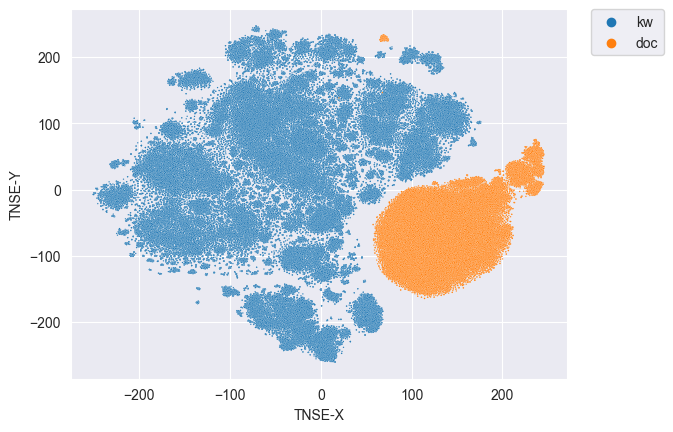

In [42]:
wos_plot = tnse_nlp.merge(tnse_data, on=record_col)

g = sns.scatterplot(wos_plot, x="TNSE-X", y="TNSE-Y",
                    hue='Type', s=1)
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# wos_plot.head()
# wos_nlp = wos_plot[[record_col, "Document", "keyword_all", "TNSE-X", "TNSE-Y"]]


In [ ]:
wos_nlp = wos.merge(wos_kwd_concat, on=record_col)
wos_nlp["Document"] = wos_nlp["Article Title"].str.cat(wos_nlp[["Abstract", "keyword_all"]].fillna(""), sep=' - ')
# wos_kwd_test["BERT_KWDS"] = wos_kwd_test["Document"].map(kwd_extract)

vectors = list()
vector_norms = list()

for doc in nlp.pipe(wos_nlp['Document'].astype('unicode').values, batch_size=300,
                    n_process=4):
    vectors.append(doc.vector)
    vector_norms.append(doc.vector_norm)

wos_nlp['vector'] = vectors
wos_nlp['vector_norm'] = vector_norms
wos_nlp['vector_norm'].plot(kind="hist")

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline

vector_data = pd.DataFrame(wos_nlp["vector"].to_list(), index=wos_nlp[record_col]).reset_index()
vector_data.head()

labels = vector_data.values[:, 0]
record_vectors = vector_data.values[:, 1:]

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=42, metric='cosine')
tnse_2d = tsne_model.fit_transform(record_vectors)
tnse_data = pd.DataFrame(tnse_2d, index=labels).reset_index()
tnse_data.columns = [record_col, "TNSE-X", "TNSE-Y"]
tnse_data.head()

In [ ]:
wos_plot = wos_nlp.merge(tnse_data, on=record_col)

g = sns.scatterplot(wos_plot[wos_plot["Domain_English"] != 'article-level classification'], x="TNSE-X", y="TNSE-Y",
                    hue='Domain_English', s=1)
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
wos_plot.head()
wos_nlp = wos_plot[[record_col, "Document", "keyword_all", "TNSE-X", "TNSE-Y"]]


In [ ]:

wos_nlp.to_excel(f"{outdir}/wos_nlp.xlsx", index=False)

In [ ]:
wos_nlp.to_csv(f"{outdir}/wos_nlp.csv", index=False, sep='\t')

In [ ]:
wos_nlp.columns

In [ ]:
import spacy

nlp = spacy.load("en_core_web_lg")
kwd_nlp = pd.DataFrame(kw_df["keyword_all"].drop_duplicates())
# wos_kwd_test["BERT_KWDS"] = wos_kwd_test["Document"].map(kwd_extract)

vectors = list()
vector_norms = list()

for doc in nlp.pipe(kwd_nlp['keyword_all'].astype('unicode').values, batch_size=300,
                    n_process=4):
    vectors.append(doc.vector)
    vector_norms.append(doc.vector_norm)

kwd_nlp['vector'] = vectors
kwd_nlp['vector_norm'] = vector_norms
kwd_nlp['vector_norm'].plot(kind="hist")

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline

vector_data = pd.DataFrame(kwd_nlp["vector"].to_list(), index=kwd_nlp["keyword_all"]).reset_index()
vector_data.head()

labels = vector_data.values[:, 0]
record_vectors = vector_data.values[:, 1:]

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=42, metric='cosine')
tnse_2d = tsne_model.fit_transform(record_vectors)
tnse_data = pd.DataFrame(tnse_2d, index=labels).reset_index()
tnse_data.columns = [record_col, "TNSE-X", "TNSE-Y"]
tnse_data.head()

In [ ]:
g = sns.scatterplot(tnse_data, x="TNSE-X", y="TNSE-Y", s=1)
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
wos_nlp.to_csv(f"{outdir}/wos_nlp.csv", index=False, sep='\t')
tnse_data.to_csv(f"{outdir}/kw_nlp.csv", index=False, sep='\t')

wos_nlp.to_excel(f"{outdir}/wos_nlp.xlsx", index=False)
tnse_data.drop_duplicates(subset=record_col).to_excel(f"{outdir}/kw_nlp.xlsx", index=False)